# Introduction

##### The past summer of 2022 was the hottest year on record in Europe, and this climate change is causing an increase in wildfire intensity and a longer wildfire season, posing a greater threat to local populations. Most of these people are increasingly adopting social media, and sites such as Twitter are increasingly being used as real-time human sensor networks during natural disasters; detecting, tracking, and recording events.
##### Sentiment analysis has been used in the past to identify dynamic polarity of sentiments over the course of a disaster, gauge polarity in online reviews, and social media posts， and help evaluate levels of destruction in local areas, identify people or communities displaced or in need of rescue efforts, and improve overall disaster management and mitigation.
##### We therefore chose to gather wildfire-related tweets from Twitter, and analyze those tweets using sentiment analysis etc.

## Install Libraries

In [2]:
import pandas as pd
import numpy as np
import datetime
import tweepy
import re
import spacy
import glob
import gensim
import gensim.corpora as corpora
import spacy
import nltk
import pyLDAvis
import pyLDAvis.gensim_models
import string
from nltk.stem.wordnet import WordNetLemmatizer
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from textblob import TextBlob
import datetime
from datetime import datetime

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from cleantext import clean

import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

import wildfire_functions 

c:\Users\Leah-\AppData\Local\Programs\Python\Python38\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [3]:
from itertools import chain

In [4]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\Leah-\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\Leah-\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\Leah-\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\Leah-\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\Leah-\AppData\Roaming\nltk_data...
[nltk_data]    | 

True

# API

##### In order to pull tweets from twitter, we decided to use tweepy library. Firstly we needed keys for using twitter API, so applied for developer account from twitter. After revieving keys we started to pull all related tweets from last one week. Then download and save as a csv file, which is privately emailed due to Tweet's privacy policy.

In [5]:
# Authentication
api_key = "Please insert your key"
api_key_secret = "Please insert your key"
access_key = "Please insert your key"
access_key_secret = "Please insert your key"

auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_key, access_key_secret)

api = tweepy.API(auth, wait_on_rate_limit = True)

# Gathering the Data

In [6]:
tweets = tweepy.Cursor(api.search_tweets, q = "wildfire -filter:retweets", lang = "en").items(15000)

In [7]:
%%time
tweet_list = []
tweet_date = []
tweet_rt = []
tweet_fav = []

for tweet in tweets:
    tweet_list.append(tweet.text)
    tweet_date.append(tweet.created_at)
    tweet_rt.append(tweet.retweet_count)
    tweet_fav.append(tweet.favorite_count)
    
wildfire = pd.DataFrame({"tweets": tweet_list, "date": tweet_date, "rt": tweet_rt, "fav": tweet_fav})

Unauthorized: 401 Unauthorized
89 - Invalid or expired token.

In [8]:
wildfire.to_csv("wildfire.csv")

NameError: name 'wildfire' is not defined

# Data

In [9]:
wf = wildfire_functions.WildfireFunctions("wildfire.csv")

In [10]:
wildfire = wf.load_file()
wildfire.head()

,Unnamed: 0,tweets,date,rt,fav
0,0,Blue Mountains Wildfire January 1994 https://t...,14/08/2022 14:12,0,0.0
1,1,*Flashback*\n\nAugust 2017... wildfire Smoke b...,14/08/2022 14:10,0,0.0
2,2,@Ebuka243 just like a wildfire🦍,14/08/2022 14:10,0,0.0
3,3,Europe's blistering summer may not be over yet...,14/08/2022 14:10,0,0.0
4,4,Pretty serious #wildfire at Newgale right now ...,14/08/2022 14:09,1,1.0


##### We get a dataframe with four main columns: tweets, date, rt(retweets) and fav(likes).

# Data Preprocessing

##### For further anaylsis we need to have clean tweets so we decided to remove links usernames stopwords and punctuations.

In [11]:
wf.cleaning_tweets()

0                            blue mountain wildfir januari
1        flashback august wildfir smoke block sun midda...
2                                             like wildfir
3        europ blister summer may yet alreadi break rec...
4        pretti seriou wildfir newgal right pembrokeshi...
                               ...                        
14950    abl go immedi say media "russia target civilia...
14951    devast particular karuk yurok tribe tri protec...
14952    ow play wgmu wildfir clean brockhampton best year
14953    want life reduc bag due wildfir flood would ra...
14954                                              wildfir
Name: tweets, Length: 14955, dtype: object

# Word Cloud

In [12]:
from wordcloud import WordCloud

In [13]:
text = " ".join(i for i in wf.clean_tweets)                                

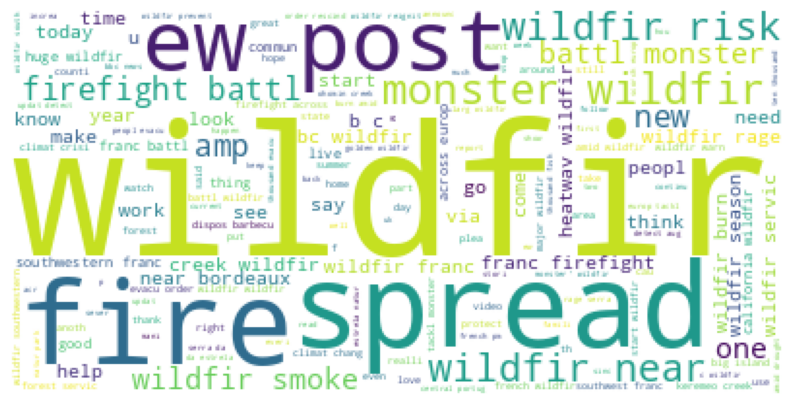

In [14]:
wordcloud = WordCloud(max_font_size = 100,
                      background_color = "white").generate(text)

plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

##### Here we create a general wordcloud from the clean tweets we got in the previous step. We can observed several word: wildfire, spread, monster, post, risk, near, firefight etc.

# nGram

#### We wanted to see the most frequent words group in order to understand the tweets more.

In [15]:
#n2_bigram
n2_bigrams = wf.get_top_n_gram(wf.clean_tweets,(2,2),20)
n2_bigrams

[('like wildfir', 978),
 ('spread like', 669),
 ('monster wildfir', 625),
 ('ew post', 606),
 ('wildfir risk', 447),
 ('wildfir near', 443),
 ('battl monster', 381),
 ('firefight battl', 378),
 ('wildfir smoke', 342),
 ('wildfir burn', 313),
 ('creek wildfir', 304),
 ('near bordeaux', 271),
 ('wildfir rage', 244),
 ('franc firefight', 214),
 ('wildfir season', 212),
 ('wildfir franc', 188),
 ('heatwav wildfir', 168),
 ('wildfir servic', 157),
 ('bc wildfir', 156),
 ('southwestern franc', 146)]

##### In the bigram, we can see the top 20 words in wildfire-related tweets and their occur times. The most frequent words are 'like wildfire', 978 times; the second are 'spread like', 669 times.

In [16]:
#n3_trigram
n3_trigrams = wf.get_top_n_gram(wf.clean_tweets,(3,3),20)
n3_trigrams

[('spread like wildfir', 617),
 ('battl monster wildfir', 364),
 ('monster wildfir near', 260),
 ('wildfir near bordeaux', 257),
 ('firefight battl monster', 236),
 ('franc firefight battl', 199),
 ('bc wildfir servic', 131),
 ('hawaii big island', 125),
 ('keremeo creek wildfir', 125),
 ('monster wildfir franc', 123),
 ('franc battl monster', 119),
 ('tackl monster wildfir', 109),
 ('wildfir southwestern franc', 109),
 ('firefight europ tackl', 90),
 ('europ tackl monster', 90),
 ('updat detect aug', 87),
 ('evacu order rescind', 83),
 ('french wildfir reignit', 82),
 ('serra da estrela', 82),
 ('estrela natur park', 80)]

##### Here is trigram. The most frequent 3-words are 'spread like wildfire'. However, "To spread like wildfire" is a common idiom in English, meaning something that "quickly affects or becomes known by more and more people". We have reason to think that these three words have little to do with real wildfires. For sure, we can filter those tweets with 'spread like wildfire' by below steps.

In [17]:
wildfire = pd.concat([wf.clean_tweets,wf.fav,wf.rt],axis=1)
wildfire.head(10)

,tweets,fav,rt
0,blue mountain wildfir januari,0.0,0
1,flashback august wildfir smoke block sun midda...,0.0,0
2,like wildfir,0.0,0
3,europ blister summer may yet alreadi break rec...,0.0,0
4,pretti seriou wildfir newgal right pembrokeshi...,1.0,1
5,major wildfir spain forc evacu,0.0,0
6,wildflow wildfir,1.0,0
7,fire spread inland due onshor breez toward hou...,0.0,0
8,jame still wear flower,1.0,0
9,europ set record wildfir destruct,0.0,0


In [15]:
wildfire[wildfire.tweets.str.find('spread like wildfire')!= -1].sort_values('fav', ascending = False)

,tweets,fav,rt
2476,"talk elderli ladi terrifi leav hous ""monkeypox...",5.0,0
2984,"atheism among muslim ""spread like wildfire"" ""if",1.0,1


In [18]:
#n4_quadgram
n4_quadgrams = wf.get_top_n_gram(wf.clean_tweets,(4,4),20)
n4_quadgrams

[('monster wildfir near bordeaux', 244),
 ('battl monster wildfir near', 236),
 ('firefight battl monster wildfir', 229),
 ('franc firefight battl monster', 194),
 ('franc battl monster wildfir', 118),
 ('firefight europ tackl monster', 90),
 ('europ tackl monster wildfir', 90),
 ('tackl monster wildfir franc', 90),
 ('drought hawaii big island', 79),
 ('wildfir burn amid drought', 78),
 ('burn amid drought hawaii', 78),
 ('amid drought hawaii big', 78),
 ('serra da estrela natur', 76),
 ('da estrela natur park', 76),
 ('wildfir rage serra da', 75),
 ('rage serra da estrela', 74),
 ('estrela natur park mountain', 74),
 ('natur park mountain region', 74),
 ('park mountain region central', 74),
 ('mountain region central portug', 74)]

##### In the quadgram, the most frequent 4-words are 'monster wildfire near bordeaux'. Then, 'monster' 'battle' 'firefight' 'france' 'europe' appear many times. It shows that people's emotions of surprise, fear and struggle, and that France has gained a lot of attention as one of the places where the wildfires occurred.

#### We can see the tweets which got mean value and the most favorites and retweets.

In [19]:
mean_fav = round(wf.fav.mean(),3)
mean_fav

6.466

In [20]:
print('top 10 favorite tweets:')
wildfire.sort_values('fav', ascending=False).head(10)

top 10 favorite tweets:


,tweets,fav,rt
2644,et congratul worker trader joe minneapoli vote...,5204.0,612
7565,franc ask help amid wildfir crisi poland annou...,1726.0,222
1494,pot malvern hill everyth tinder dri miracl sta...,1689.0,577
12334,canada lesli dart plant tree one day burn scar...,1416.0,281
1531,chapter wildfir tartali eng translat part lt l...,1170.0,298
1254,next summer could real troubl dr rob thompson ...,1013.0,351
2699,danger like defamatori lie judg sign trump sea...,888.0,241
2113,peopl realiz major emerg vultur go extinct yea...,843.0,161
3964,'monster' wildfir rip franc heatwav scorch eur...,742.0,388
10172,danger insan bullshit realli fox news brain po...,734.0,182


##### From the top 10 favorite tweets, We can see tweet users' widely accepted sentiment towards wildfires.

In [21]:
mean_rt = round(wf.rt.mean(),3)
mean_rt

1.904

In [22]:
print ('top 10 retweets:')
wildfire.sort_values('rt', ascending=False).head(10)

top 10 retweets:


,tweets,fav,rt
2644,et congratul worker trader joe minneapoli vote...,5204.0,612
1494,pot malvern hill everyth tinder dri miracl sta...,1689.0,577
5206,awp wildfir giveaway follow amp turn notif ret...,411.0,522
13511,awp wildfir giveaway retweet amp follow like a...,445.0,511
3964,'monster' wildfir rip franc heatwav scorch eur...,742.0,388
1254,next summer could real troubl dr rob thompson ...,1013.0,351
9705,awp wildfir giveaway retweet amp follow like a...,257.0,328
10882,judg sign fbi trump home raid obama donor tie ...,617.0,321
7037,awp wildfir giveaway retweet amp follow like a...,251.0,308
1531,chapter wildfir tartali eng translat part lt l...,1170.0,298


##### From the top 10 retweets, in addition to group resonance, there are also group appeals that can be reflected here.

# Feature Extraction

#### We continue with extracting hashtags and users to have more information from tweets

In [23]:
# create new columns for mentioned usernames and hashtags
wf.mentioned = wf.tweet.apply(wf.find_mentioned)
wf.hashtags = wf.tweet.apply(wf.find_hashtags)

In [24]:
wildfire = pd.concat([wf.clean_tweets,wf.fav,wf.rt, wf.mentioned, wf.hashtags],axis=1)
wildfire.head(10)

,tweets,fav,rt,tweets,tweets
0,blue mountain wildfir januari,0.0,0,[],[]
1,flashback august wildfir smoke block sun midda...,0.0,0,[],[]
2,like wildfir,0.0,0,[@Ebuka243],[]
3,europ blister summer may yet alreadi break rec...,0.0,0,[],[]
4,pretti seriou wildfir newgal right pembrokeshi...,1.0,1,[],"[#wildfire, #Pembrokeshire, #Wales, #wildfires..."
5,major wildfir spain forc evacu,0.0,0,[],[]
6,wildflow wildfir,1.0,0,[@honeysgroove],[]
7,fire spread inland due onshor breez toward hou...,0.0,0,[@BBCNews],"[#newgale, #newgalebeach]"
8,jame still wear flower,1.0,0,[@wildfire__xo],[]
9,europ set record wildfir destruct,0.0,0,[],[]


In [26]:
wildfire.columns.values[3] = "mentioned"
wildfire.columns.values[4] = "hashtags"

In [27]:
wildfire.head()

,tweets,fav,rt,mentioned,hashtags
0,blue mountain wildfir januari,0.0,0,[],[]
1,flashback august wildfir smoke block sun midda...,0.0,0,[],[]
2,like wildfir,0.0,0,[@Ebuka243],[]
3,europ blister summer may yet alreadi break rec...,0.0,0,[],[]
4,pretti seriou wildfir newgal right pembrokeshi...,1.0,1,[],"[#wildfire, #Pembrokeshire, #Wales, #wildfires..."


In [28]:
# extract the rows from the hashtag columns where there are actually hashtags
hashtags_list_wildfire = wildfire.loc[
                       wf.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]

In [29]:
# create dataframe where each use of hashtag gets its own row
flattened_hashtags_wildfire = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_wildfire.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])

flattened_hashtags_wildfire

,hashtag
0,#wildfire
1,#Pembrokeshire
2,#Wales
3,#wildfires
4,#StormHour
...,...
4278,#TeenReads
4279,#Climatecrisis
4280,#California
4281,#wildfires


In [30]:
# count of appearances of each hashtag
flattened_hashtags_wildfire.hashtag = flattened_hashtags_wildfire.hashtag.str.upper()

popular_hashtags = flattened_hashtags_wildfire.groupby('hashtag').size().reset_index(name='counts').sort_values('counts', ascending=False).reset_index(drop=True)
popular_hashtags.head(10)

,hashtag,counts
0,#WILDFIRE,604
1,#WILDFIRES,217
2,#HEATWAVE,171
3,#FRANCE,114
4,#CALIFORNIA,46
5,#PENTICTON,46
6,#FIRE,40
7,#BCWILDFIRE,40
8,#SK,38
9,#CLIMATECRISIS,36


##### We can see the most popular hashtags are wildfire and wildfires. Then, #heatwave, it reflects the most direct impact of wildfires on people. Other hashtags "#france", "#california", "#penticton" and "#SK" shows the place with wildfire. Wildfires in France attract more attention. And there are 36 times "#climatecrisis", someone focus on the global crisis after wildfires.

In [31]:
# extact hashtags which appear at least 10 times and find popular hashtags
min_appearance = 10
popular_hashtags_set = set(popular_hashtags[
                           popular_hashtags.counts>=min_appearance
                           ]['hashtag'])

In [32]:
# create a new column with only the popular hashtags
hashtags_list_wildfire['popular_hashtags'] = hashtags_list_wildfire.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list
                                  if hashtag in popular_hashtags_set])

In [33]:
# drop rows without popular hashtag
popular_hashtags_list_wildfire = hashtags_list_wildfire.loc[hashtags_list_wildfire.popular_hashtags.apply(
    lambda hashtag_list: hashtag_list !=[])]

In [34]:
hashtag_vector_wildfire = popular_hashtags_list_wildfire.loc[:, ['popular_hashtags']]
for hashtag in popular_hashtags_set:
    hashtag_vector_wildfire['{}'.format(hashtag)] = hashtag_vector_wildfire.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))

hashtag_matrix = hashtag_vector_wildfire.drop('popular_hashtags', axis=1)


In [35]:
wf.get_top_abs_correlations(df=hashtag_matrix,n=15)

#WILDFIRE      #UK          0.505099
#BREAKING      #WILDFIRE    0.474902
#WILDFIRE      #GPWX        0.373035
#FIREFIGHTERS  #CLIMATE     0.302564
#GPWX          #UK          0.258641
#FIREFIGHTERS  #WILDFIRE    0.256776
#CLIMATE       #WILDFIRE    0.256776
#BREAKING      #GPWX        0.246266
#WORLDNEWS     #WILDFIRE    0.208063
#WILDFIRES     #WILDFIRE    0.145644
#FIREFIGHTERS  #GPWX        0.114291
               #UK          0.104447
#CLIMATE       #UK          0.104447
#FIRE          #WILDFIRE    0.102214
#WILDFIRE      #DROUGHT     0.102214
dtype: float64

##### This part is to check how hashtags are correlated with each other. And since there are a lot hashtags we only showed top 15 correlation.

In [36]:
mentioned_list_wildfire = wildfire.loc[
                       wf.mentioned.apply(
                           lambda mentioned_list: mentioned_list !=[]
                       ),['mentioned']]

In [37]:
flattened_mentioned_wildfire = pd.DataFrame(
    [mentioned for mentioned_list in mentioned_list_wildfire.mentioned
    for mentioned in mentioned_list],
    columns=['mentioned'])

In [38]:
flattened_mentioned_wildfire.mentioned = flattened_mentioned_wildfire.mentioned.str.upper()

In [39]:
flattened_mentioned_wildfire.mentioned = flattened_mentioned_wildfire.mentioned.str.upper()
popular_mentioned = flattened_mentioned_wildfire.groupby('mentioned').size().reset_index(name='counts')                                        .sort_values('counts', ascending=False)                                        .reset_index(drop=True)
popular_mentioned.head(10)

,mentioned,counts
0,@MISS_WILDFIRE,78
1,@YOUTUBE,63
2,@MAILONLINE,42
3,@MRANDYNGO,30
4,@BCGOVFIREINFO,28
5,@WILDFIRE_1980,24
6,@WILDFIRE__XO,23
7,@FRANCE24,22
8,@SMOKEY_BEAR,20
9,@HAPPYDOG___,18


##### From the counts of "mentioned", the most mentioned are "@MISS_WILDFIRE", and various official accounts related to wildfires. The second most mentioned is "@YOUTUBE", and the third most is "@MAILONLINE". "@FRANCE24" has also been mentioned many times, which once again reflects people's surprise and concern about the wildfire in France.

# Topic Modelling

Since our data has many unstructured text bodies, we have decieded to use topic modelling to help for for the organization and getting insights from our data.

In [40]:
wf.sep_tweets = wf.clean_tweets.apply(wf.separate_tweets)

In [41]:
wf.sep_tweets

0                       [blue, mountain, wildfir, januari]
1        [flashback, august, wildfir, smoke, block, sun...
2                                          [like, wildfir]
3        [europ, blister, summer, may, yet, alreadi, br...
4        [pretti, seriou, wildfir, newgal, right, pembr...
                               ...                        
14950    [abl, go, immedi, say, medium, russia, target,...
14951    [devast, particular, karuk, yurok, tribe, tri,...
14952    [ow, play, wgmu, wildfir, clean, brockhampton,...
14953    [want, life, reduc, bag, due, wildfir, flood, ...
14954                                            [wildfir]
Name: tweets, Length: 14955, dtype: object

In [42]:
#create dictionary
dictionary = corpora.Dictionary(wf.sep_tweets)
#Total number of non-zeroes in the BOW matrix(sum of the number of unique words per document over the entire corpus)
print(dictionary.num_nnz)

136854


### Create document term matrix

In [43]:
#create document term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in wf.sep_tweets ] #bag of words
print(len(doc_term_matrix))

14955


### Instantiate LDA Model

In [44]:
lda = gensim.models.ldamodel.LdaModel

### Fit LDA model to our wildfire dataset

In [45]:
num_topics = 3
%time ldamodel = lda(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=50, minimum_probability=0)

CPU times: total: 2min 19s
Wall time: 2min 29s


### Print the topics identified by LDA model

In [46]:
ldamodel.print_topics(num_topics=num_topics)

[(0,
  '0.092*"wildfir" + 0.032*"franc" + 0.029*"firefight" + 0.018*"battl" + 0.015*"monster" + 0.013*"near" + 0.009*"europ" + 0.009*"via" + 0.008*"rage" + 0.008*"thousand"'),
 (1,
  '0.078*"wildfir" + 0.026*"fire" + 0.010*"burn" + 0.009*"risk" + 0.009*"smoke" + 0.008*"creek" + 0.008*"servic" + 0.007*"c" + 0.006*"b" + 0.006*"warn"'),
 (2,
  '0.047*"wildfir" + 0.026*"like" + 0.017*"spread" + 0.013*"post" + 0.013*"ew" + 0.005*"california" + 0.005*"say" + 0.005*"one" + 0.005*"go" + 0.004*"start"')]

### Visualize the LDA model result

In [47]:
lda_display = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

# Sentiment Analysis

In [48]:
#Create two new columns 
wf.subjectivity = wf.clean_tweets.apply(wf.getSubjectivity)
wf.polarity = wf.clean_tweets.apply(wf.getPolarity)

#show the new data
wildfire = pd.concat([wildfire,wf.subjectivity,wf.polarity],axis=1)


In [49]:
wildfire.columns.values[5] = "subjectivity"
wildfire.columns.values[6] = "polarity"

In [50]:
wildfire.head(10)

,tweets,fav,rt,mentioned,hashtags,subjectivity,polarity
0,blue mountain wildfir januari,0.0,0,[],[],0.100000,0.000000
1,flashback august wildfir smoke block sun midda...,0.0,0,[],[],0.000000,0.000000
2,like wildfir,0.0,0,[@Ebuka243],[],0.000000,0.000000
3,europ blister summer may yet alreadi break rec...,0.0,0,[],[],0.000000,0.000000
4,pretti seriou wildfir newgal right pembrokeshi...,1.0,1,[],"[#wildfire, #Pembrokeshire, #Wales, #wildfires...",0.535714,0.285714
5,major wildfir spain forc evacu,0.0,0,[],[],0.500000,0.062500
6,wildflow wildfir,1.0,0,[@honeysgroove],[],0.000000,0.000000
7,fire spread inland due onshor breez toward hou...,0.0,0,[@BBCNews],"[#newgale, #newgalebeach]",0.375000,-0.125000
8,jame still wear flower,1.0,0,[@wildfire__xo],[],0.000000,0.000000
9,europ set record wildfir destruct,0.0,0,[],[],0.000000,0.000000


In [51]:
wf.analysis = wf.polarity.apply(wf.getAnalysis)

#Show the data
wildfire = pd.concat([wildfire,wf.analysis],axis=1)
wildfire.columns.values[7] = "analysis"


In [52]:
wildfire.head()

,tweets,fav,rt,mentioned,hashtags,subjectivity,polarity,analysis
0,blue mountain wildfir januari,0.0,0,[],[],0.100000,0.000000,Neutral
1,flashback august wildfir smoke block sun midda...,0.0,0,[],[],0.000000,0.000000,Neutral
2,like wildfir,0.0,0,[@Ebuka243],[],0.000000,0.000000,Neutral
3,europ blister summer may yet alreadi break rec...,0.0,0,[],[],0.000000,0.000000,Neutral
4,pretti seriou wildfir newgal right pembrokeshi...,1.0,1,[],"[#wildfire, #Pembrokeshire, #Wales, #wildfires...",0.535714,0.285714,Positive


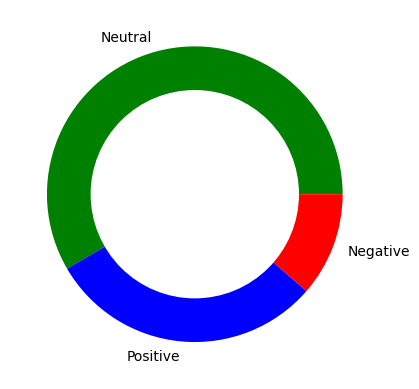

In [53]:
total=wildfire.loc[:, "analysis"].value_counts(dropna=False)
percentage=round(wildfire.loc[:, "analysis"].value_counts(dropna=False,normalize=True)*100,2)
pichart = pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
names= pichart.index
size=pichart["Percentage"]
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### Moving Average

In [54]:
wildfire = pd.concat([wildfire,wf.date,wf.sep_tweets],axis=1)
wildfire.columns.values[8] = "date"
wildfire.columns.values[9] = "sep_tweets"


In [55]:
wildfire.head()

,tweets,fav,rt,mentioned,hashtags,subjectivity,polarity,analysis,date,sep_tweets
0,blue mountain wildfir januari,0.0,0,[],[],0.100000,0.000000,Neutral,14/08/2022 14:12,"[blue, mountain, wildfir, januari]"
1,flashback august wildfir smoke block sun midda...,0.0,0,[],[],0.000000,0.000000,Neutral,14/08/2022 14:10,"[flashback, august, wildfir, smoke, block, sun..."
2,like wildfir,0.0,0,[@Ebuka243],[],0.000000,0.000000,Neutral,14/08/2022 14:10,"[like, wildfir]"
3,europ blister summer may yet alreadi break rec...,0.0,0,[],[],0.000000,0.000000,Neutral,14/08/2022 14:10,"[europ, blister, summer, may, yet, alreadi, br..."
4,pretti seriou wildfir newgal right pembrokeshi...,1.0,1,[],"[#wildfire, #Pembrokeshire, #Wales, #wildfires...",0.535714,0.285714,Positive,14/08/2022 14:09,"[pretti, seriou, wildfir, newgal, right, pembr..."


In [56]:
wildfire = wildfire.sort_values(by='date', ascending=True)
wf.ma_polarity = wf.polarity.rolling(10, min_periods=5).mean()

In [57]:
wildfire.head()

,tweets,fav,rt,mentioned,hashtags,subjectivity,polarity,analysis,date,sep_tweets
14954,wildfir,0.0,0,[@SadiqMaunde],[],0.000000,0.000000,Neutral,07/08/2022 08:10,[wildfir]
14953,want life reduc bag due wildfir flood would ra...,6.0,6,[],[],0.375000,-0.125000,Negative,07/08/2022 08:12,"[want, life, reduc, bag, due, wildfir, flood, ..."
14952,ow play wgmu wildfir clean brockhampton best year,0.0,0,[],[],0.500000,0.683333,Positive,07/08/2022 08:28,"[ow, play, wgmu, wildfir, clean, brockhampton,..."
14951,devast particular karuk yurok tribe tri protec...,1.0,2,[],[],0.333333,0.166667,Positive,07/08/2022 08:32,"[devast, particular, karuk, yurok, tribe, tri,..."
14950,"abl go immedi say media ""russia target civilia...",0.0,0,[@Joe71545644],[],0.000000,0.000000,Neutral,07/08/2022 08:33,"[abl, go, immedi, say, medium, russia, target,..."


In [58]:
wf.date = pd.to_datetime(wf.date, format = "%d/%m/%Y %H:%M") #convert it to the date

Text(0.5, 1.0, 'Wildfires 10 Tweet Moving Average')

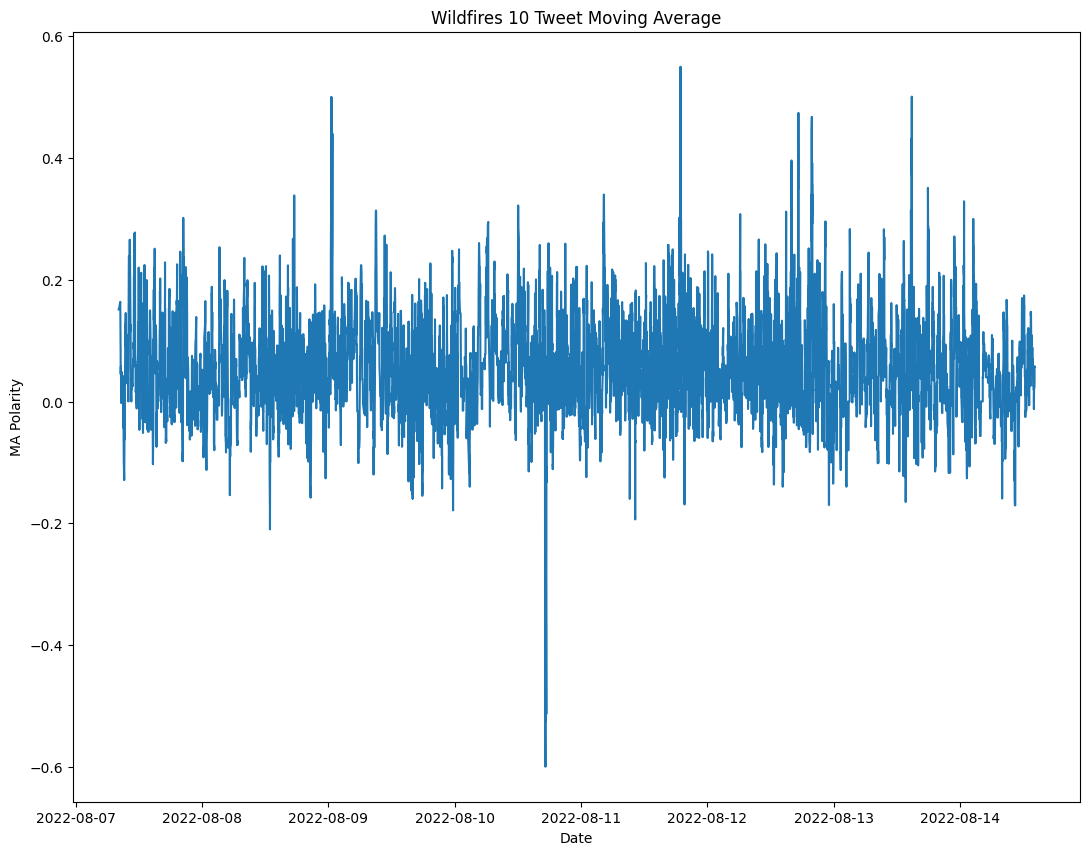

In [59]:
# Use similar to plt.figure() except use tuple unpacking to grab fig and axes
fig, axes = plt.subplots(figsize=(13,10))

# axes object to add stuff to plot
axes.plot(wf.date, wf.ma_polarity)
axes.set_xlabel('Date')
axes.set_ylabel('MA Polarity')
axes.set_title('Wildfires 10 Tweet Moving Average')

### Create Word Cloud for Positive and Negative Tweets

In [60]:
positive_tweets = wildfire[wildfire["analysis"] == "Positive"]["sep_tweets"]
negative_tweets = wildfire[wildfire["analysis"] == "Negative"]["sep_tweets"]

In [61]:
text_positive = " ".join(' '.join(map(str, i)) for i in positive_tweets)

In [62]:
text_negative = " ".join(' '.join(map(str, i)) for i in negative_tweets)

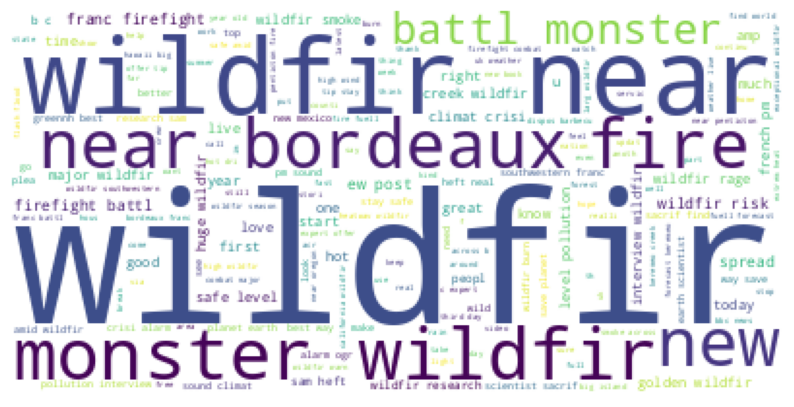

In [63]:
wordcloud = WordCloud(max_font_size = 100,
                      background_color = "white").generate(text_positive)

plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

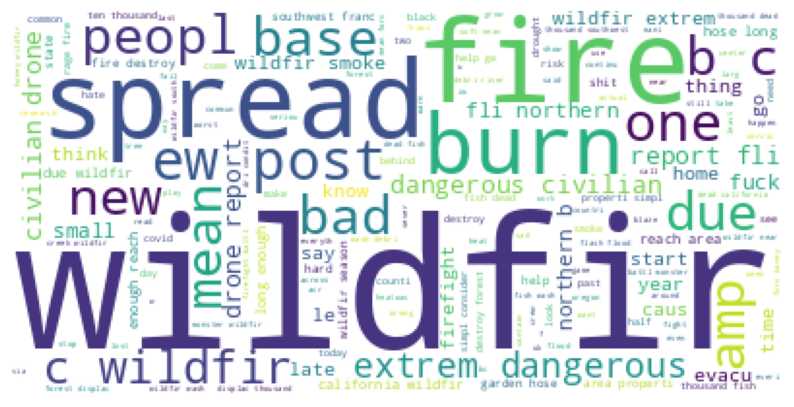

In [64]:
wordcloud = WordCloud(max_font_size = 100,
                      background_color = "white").generate(text_negative)

plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Summary

##### In this project, we pull tweets from twitter and make Exploratory Data Analysis. After doing some cleaning and preprossesing we tried to extract more information from tweets. Wordcloud and ngrams analysis helped us to understand the tweets. Topic modeling with LDA, and Sentiment analysis help to understand more trend about wildfire, and predict. 